In [1]:
# Essentials
import numpy as np
import pandas as pd

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models Regression
import lightgbm as lgb

# Models Classification
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Misc
import math
import shap
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope 
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

# Feature Selection
from sklearn.feature_selection import VarianceThreshold
from sklearn.base import BaseEstimator, TransformerMixin


import warnings
warnings.filterwarnings("ignore")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Utils

In [2]:
def scoringProfit(yTrue, pred, doubleAnalysis = False):
    '''
        Custrom metric to compute profit where TP = 90 and
        FP = -10 in generating the metric
        
        Args:
            yTrue: Array with ground truth
            pred: Array with predict from model
            doubleAnalysis: Boolean to say if return one metric or two
            
        Returns:
            Scorer: Scorer of  profit by customer or 
                    profit by customer and all profit
    '''
    
    # ### Matriz de confusão com (tn,fp,fn,tp)
    crosstab = metrics.confusion_matrix(yTrue, pred)
    
    if len(pred) < 4:
        tn, fp, fn, tp = 0, 0, 0, 0
    else:
        tn, fp, fn, tp = crosstab.ravel()
    
    # Compute profit
    profit = (tp*90 - fp*10)
    
    # Compute profit per customer
    profitCustomer = profit/len(pred)

    if doubleAnalysis:
        return profitCustomer, profit
        
    return profitCustomer



In [3]:
def thresholdsCurve(y_true = None, y_proba = None):
  '''
      Calculate the best threshold to maximize profit
      
      Args:
        y_true (np.array):
        y_proba (np.array):
  '''
    
  thresholds = np.arange(0.0, 1.0, 0.01)
  threshold_gain_max = 0.0

  gain_score_eval = list()
  gain_score_max = 0.0

  gain_tp = 90
  gain_fp = -10

  for threshold in thresholds:
    y_pred = np.array(list(map(lambda proba: 1 if proba >= threshold else 0, y_proba[:, 1])))
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    total_clientes = int(tp + tn + fp + fn)
    gain = round((tp * gain_tp + fp * gain_fp) / total_clientes, 2)

    gain_score_eval.append(gain)

    if gain >= gain_score_max and threshold >= threshold_gain_max:
      gain_score_max = gain
      threshold_gain_max = threshold
  
  plt.figure(figsize= (5, 5))
  sns.lineplot(x = thresholds, y = gain_score_eval, color= "red")

  plt.text(x = 0.45,
           y = gain_score_max*1.1,
           s = f"THRESHOLD: {threshold_gain_max:.2f},\nLucro Per. Cliente (R$): {gain_score_max:.2f}", 
           bbox = {'facecolor': 'gray','alpha': 0.4, 'pad': 6}
  )

  plt.title("Curva Lucro Per. Cliente(R$) x THRESHOLD")
  plt.legend(["Classe 1 - Insatisfeito"])
  plt.ylim(0, gain_score_max*1.35)
  plt.ylabel("Lucro Per. Cliente(R$)")
  plt.xlabel("Thresholds")
  plt.show()

In [4]:
def computeDist(yTrue, yPred_prob):
    '''
      Calculate the distribution
      
      Args:
        yTrue (np.array): True label
        yPred_prob (np.array): Proba predict by model
  '''
    
    df_dist = pd.DataFrame({'Target': yTrue, 'Proba': yPred_prob[:,1]})
    df_dist.sort_values(by=['Proba'], ascending=False, inplace=True)
    df_dist.reset_index(drop=True,inplace=True)
    df_dist['Decile']=pd.qcut(df_dist.index,100,labels=False)
    
    output_df_dist = pd.DataFrame()
    output_df_dist['Percentil'] = list(range(1,101))
    grouped = df_dist.groupby('Decile',as_index=False)
    output_df_dist['Qtd']=grouped.count().Target
    output_df_dist['Sum_Target']=grouped.sum().Target
    output_df_dist['Target_perc'] = (output_df_dist['Sum_Target']/output_df_dist['Sum_Target'].sum())*100
    output_df_dist['Target_AC'] = output_df_dist.Target_perc.cumsum()
    output_df_dist['Max_proba']=grouped.max().Proba
    output_df_dist['Min_proba']=grouped.min().Proba
    output_df_dist["Per_pop"] = (output_df_dist["Qtd"]/len(yTrue))*100
    output_df_dist["Lift"] = output_df_dist["Target_AC"]/output_df_dist.Per_pop.cumsum()
    
    output_df_dist= output_df_dist.drop(columns=['Qtd', 'Sum_Target','Target_perc', 'Per_pop'])
    output_df_dist = output_df_dist.set_index('Percentil')
    
    return output_df_dist.iloc[[0,4, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99]]

In [5]:
def dropDuplicatedRows(df, cols, keep=False):
    print(f'Dataset antes do processamento: {df.shape}')
    dfResult = df.drop_duplicates(subset=cols, inplace=False,keep=keep)
    print(f'Dataset após o processamento: {dfResult.shape}')
    return dfResult

# Carregamento dos Dados

In [6]:
dfTrain = pd.read_csv('train_features.csv')
#yTrain = dfTrain.TARGET
#dfTrain = dfTrain.drop(labels=['TARGET'], axis=1)

dfVal = pd.read_csv('val_features.csv')
#yVal = dfVal.TARGET
#dfVal = dfVal.drop(labels=['TARGET'], axis=1)

dfTest = pd.read_csv('test_features.csv')

Proporção dos targets positivos no dataset de Treino: 3.78%
Número de clientes satisfeitos: 54611
Número de clientes insatisfeitos: 2146


Text(0.5, 1.0, 'Total de registros por classe')

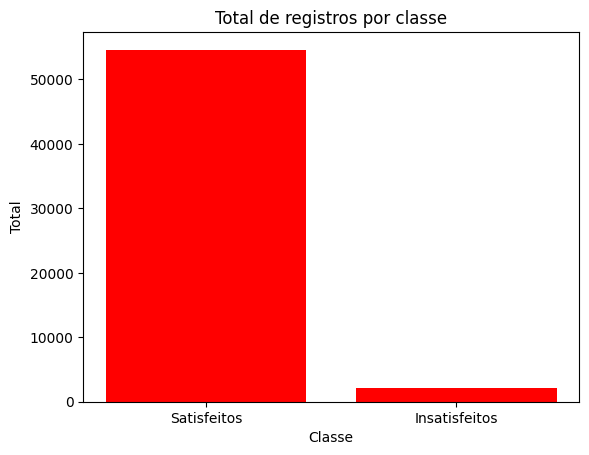

In [7]:
# ### Count by class
targetCounts  = dfTrain['TARGET'].value_counts()
dissatisfied = targetCounts[1]
satisfied   = targetCounts[0]

# ### Get proportion
prop = (dissatisfied/len(dfTrain['TARGET']))
print(f'Proporção dos targets positivos no dataset de Treino: {prop:.2%}')
print(f"Número de clientes satisfeitos: {satisfied}")
print(f"Número de clientes insatisfeitos: {dissatisfied}")
      
# Show plot 
plt.bar(['Satisfeitos', 'Insatisfeitos'] ,targetCounts,color='red')
plt.xticks([0,1])
plt.xlabel('Classe')
plt.ylabel('Total')
plt.title('Total de registros por classe')

Proporção dos targets positivos no dataset de Validação: 3.78%
Número de clientes satisfeitos: 13654
Número de clientes insatisfeitos: 536


Text(0.5, 1.0, 'Total de registros por classe')

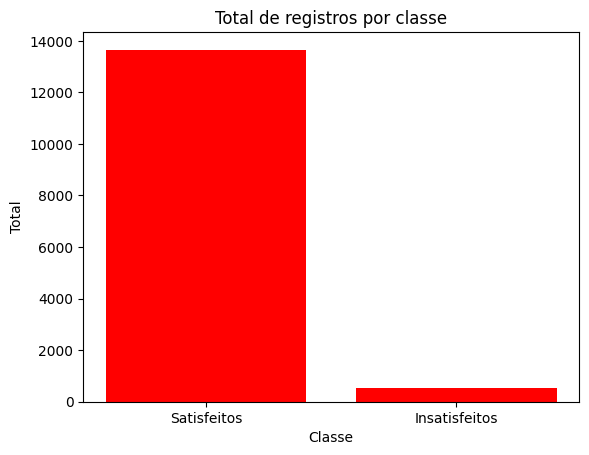

In [8]:
# ### Count by class
targetCounts  = dfVal['TARGET'].value_counts()
dissatisfied = targetCounts[1]
satisfied   = targetCounts[0]

# ### Get proportion
prop = (dissatisfied/len(dfVal['TARGET']))
print(f'Proporção dos targets positivos no dataset de Validação: {prop:.2%}')
print(f"Número de clientes satisfeitos: {satisfied}")
print(f"Número de clientes insatisfeitos: {dissatisfied}")
      
# Show plot 
plt.bar(['Satisfeitos', 'Insatisfeitos'] ,targetCounts,color='red')
plt.xticks([0,1])
plt.xlabel('Classe')
plt.ylabel('Total')
plt.title('Total de registros por classe')

# Remover dados duplicados

In [9]:
# ### Remove duplicated Data on Train and keep one element
dfTrain = dropDuplicatedRows(dfTrain, dfTrain.columns, 'last')

Dataset antes do processamento: (56757, 26)
Dataset após o processamento: (55706, 26)


In [10]:
# Remove All Duplicated elements where the target is different on Train
dfTrain = dropDuplicatedRows(dfTrain, dfTrain.columns.drop('TARGET'))

Dataset antes do processamento: (55706, 26)
Dataset após o processamento: (55626, 26)


In [11]:
# ### Remove duplicated Data on Val and keep one element
dfVal = dropDuplicatedRows(dfVal, dfVal.columns, 'last')

Dataset antes do processamento: (14190, 26)
Dataset após o processamento: (14091, 26)


In [12]:
# Remove All Duplicated elements where the target is different on Val
dfVal = dropDuplicatedRows(dfVal, dfVal.columns.drop('TARGET'))

Dataset antes do processamento: (14091, 26)
Dataset após o processamento: (14081, 26)


In [13]:
yTrain = dfTrain.TARGET
dfTrain = dfTrain.drop(labels=['TARGET'], axis=1)

yVal = dfVal.TARGET
dfVal = dfVal.drop(labels=['TARGET'], axis=1)

Proporção dos targets positivos no dataset de Treino após remoção de duplicadas: 3.77%
Número de clientes satisfeitos: 53527
Número de clientes insatisfeitos: 2099


Text(0.5, 1.0, 'Total de registros por classe')

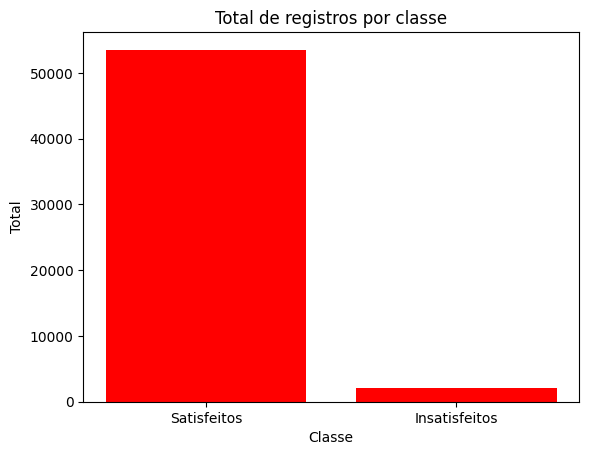

In [14]:
# ### Count by class
targetCounts  = yTrain.value_counts()
dissatisfied = targetCounts[1]
satisfied   = targetCounts[0]

# ### Get proportion
prop = (dissatisfied/len(yTrain))
print(f'Proporção dos targets positivos no dataset de Treino após remoção de duplicadas: {prop:.2%}')
print(f"Número de clientes satisfeitos: {satisfied}")
print(f"Número de clientes insatisfeitos: {dissatisfied}")
      
# Show plot 
plt.bar(['Satisfeitos', 'Insatisfeitos'] ,targetCounts,color='red')
plt.xticks([0,1])
plt.xlabel('Classe')
plt.ylabel('Total')
plt.title('Total de registros por classe')

Proporção dos targets positivos no dataset de Validação após remoção de duplicadas: 3.76%
Número de clientes satisfeitos: 13551
Número de clientes insatisfeitos: 530


Text(0.5, 1.0, 'Total de registros por classe')

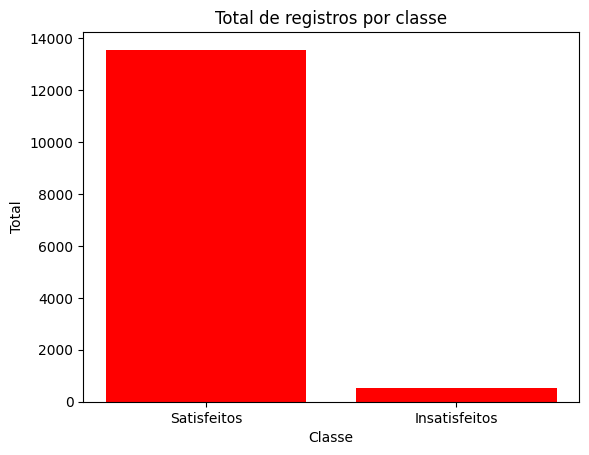

In [15]:
# ### Count by class
targetCounts  = yVal.value_counts()
dissatisfied = targetCounts[1]
satisfied   = targetCounts[0]

# ### Get proportion
prop = (dissatisfied/len(yVal))
print(f'Proporção dos targets positivos no dataset de Validação após remoção de duplicadas: {prop:.2%}')
print(f"Número de clientes satisfeitos: {satisfied}")
print(f"Número de clientes insatisfeitos: {dissatisfied}")
      
# Show plot 
plt.bar(['Satisfeitos', 'Insatisfeitos'] ,targetCounts,color='red')
plt.xticks([0,1])
plt.xlabel('Classe')
plt.ylabel('Total')
plt.title('Total de registros por classe')

# Solução

# 1.0 - Classificação (Case A)

## 1.1 - Preparação do Dataset

In [11]:
modelTransform = Pipeline(
                 [
                    ('scale', PowerTransformer(method='yeo-johnson'))
                ]
            )
modelTransform.fit(dfTrain, yTrain)

Pipeline(steps=[('scale', PowerTransformer())])

In [12]:
dfTrainCLF = modelTransform.transform(dfTrain)
dfValCLF = modelTransform.transform(dfVal)
dfTestCLF = modelTransform.transform(dfTest)

## 1.2 - Ponto de Partida

In [14]:
# Model base
clRF = RandomForestClassifier(n_jobs = -1, class_weight='balanced')
clRF.fit(dfTrainCLF, yTrain)
preds = clRF.predict(dfValCLF)
rfPerCustomer, rfProfit = scoringProfit(yVal, preds, True)

# Lucro caso a campanha impacte todos os clientes
allCustomerProfitPerCustomer, allCustomerProfit = scoringProfit(yVal, [1 for i in range(len(yVal))], True)

# Verificação do score máximo possível no treino
maxProfitPerCustomer, maxProfit = (scoringProfit(yVal, yVal, True))

print(f"Lucro no modelo base R${rfProfit:,.2f}")
print(f"Lucro por cliente no modelo base R$ {rfPerCustomer:,.2f}\n")

print(f"Lucro caso a capanha seja aplicada a todos os clientes R$ {allCustomerProfit:,.2f}")
print(f"Lucro por cliente caso a capanha seja aplicada a todos os clientes R$ {allCustomerProfitPerCustomer:,.2f}\n")

print(f"Lucro caso a capanha seja aplicada apenas aos clientes insatisfeitos R$ {maxProfit:,.2f}")
print(f"Lucro por cliente caso a capanha seja aplicada apenas aos clientes insatisfeitos R$ {maxProfitPerCustomer:,.2f}")

Lucro no modelo base R$1,270.00
Lucro por cliente no modelo base R$ 0.09

Lucro caso a capanha seja aplicada a todos os clientes R$ -87,810.00
Lucro por cliente caso a capanha seja aplicada a todos os clientes R$ -6.24

Lucro caso a capanha seja aplicada apenas aos clientes insatisfeitos R$ 47,700.00
Lucro por cliente caso a capanha seja aplicada apenas aos clientes insatisfeitos R$ 3.39


## 1.3 - Busca dos Melhores Parâmetros

### 1.3.0 - LGBM

In [15]:
def objective(params):
    classifier = lgb.LGBMClassifier(verbose = -1, 
                                    n_jobs = -1, 
                                    class_weight='balanced',
                                    objective='binary', 
                                    random_state=424, **params)

    model = Pipeline(
                 [
                    ('classifier', classifier)
                ]
            )
    
    model.fit(dfTrainCLF, yTrain)

    yPred = classifier.predict(dfValCLF)

    score = scoringProfit(yVal, yPred)

    return {
        'loss': -score,
        'status': STATUS_OK, 
    }

In [16]:
spaceLGBM = {
    'n_estimators': scope.int(hp.uniform('n_estimators', 50, 5000)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.01, 1.0),
    'learning_rate': hp.choice('learning_rate', np.arange(0.05, 0.35, 0.02)),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 20, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 3, 20, 1)),
    'subsample': hp.uniform('subsample', 0.01, 1.0),
    'reg_lambda': hp.lognormal('reg_lambda', 0.0, 1.0),
    'reg_alpha': hp.lognormal('reg_alpha', 0.0, 1.0),

}

In [17]:
trials = Trials ()

bestParamsLGBM = fmin(
    fn=objective,
    space=spaceLGBM,
    algo=tpe.suggest,
    trials=trials,
    max_evals=1000
)

100%|██| 1000/1000 [1:54:35<00:00,  6.88s/trial, best loss: -0.8444002556636603]


In [18]:
print(bestParamsLGBM)

{'colsample_bytree': 0.2903871114466451, 'learning_rate': 3, 'max_depth': 16.0, 'min_child_weight': 5.0, 'n_estimators': 2313.1681004977945, 'reg_alpha': 5.050663267632806, 'reg_lambda': 10.882386452313039, 'subsample': 0.011191504578942149}


### 1.3.1 - XGBoost

In [19]:
def objective(params):
    classifier = XGBClassifier(n_jobs = -1, objective='binary:logistic', random_state=424, **params)

    model = Pipeline(
                 [
                    ('classifier', classifier)
                ]
            )
    model.fit(dfTrainCLF, yTrain)

    yPred = classifier.predict(dfValCLF)

    score = scoringProfit(yVal, yPred)

    return {
        'loss': -score,
        'status': STATUS_OK, 
        'booster': model.named_steps['classifier'].get_booster().attributes()
    }

In [20]:
spaceXGB = {
    'n_estimators': scope.int(hp.uniform('n_estimators', 50, 5000)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.01, 1.0),
    'learning_rate': hp.choice('learning_rate', np.arange(0.05, 0.35, 0.02)),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 20, 1)),
    'scale_pos_weight': scope.int(hp.quniform('scale_pos_weight', 20, 30, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 3, 20, 1)),
    'subsample': hp.uniform('subsample', 0.01, 1.0),
    'reg_lambda': hp.lognormal('reg_lambda', 0.0, 1.0),
    'reg_alpha': hp.lognormal('reg_alpha', 0.0, 1.0)
}

In [21]:
trials = Trials ()

bestParamsXGB = fmin(
    fn=objective,
    space=spaceXGB,
    algo=tpe.suggest,
    trials=trials,
    max_evals=1000
)

100%|███| 1000/1000 [4:30:13<00:00, 16.21s/trial, best loss: -0.890561749875719]


In [22]:
print(bestParamsXGB)

{'colsample_bytree': 0.6455876980300431, 'learning_rate': 11, 'max_depth': 10.0, 'min_child_weight': 10.0, 'n_estimators': 3874.6319871673063, 'reg_alpha': 0.3291250595275096, 'reg_lambda': 5859.456517028919, 'scale_pos_weight': 20.0, 'subsample': 0.7885805149719771}


In [23]:
print(trials.best_trial['result'])

{'loss': -0.890561749875719, 'status': 'ok', 'booster': {}}


## 1.4 - Avaliar Melhor Modelo

### 1.4.0 - XGBoost

In [24]:
bestParamsXGB['learning_rate'] = np.arange(0.05, 0.35, 0.02)[11]
bestParamsXGB['n_estimators'] = int(bestParamsXGB['n_estimators'])
bestParamsXGB['max_depth'] = int(bestParamsXGB['max_depth'])

In [25]:
classifierXGB = XGBClassifier(n_jobs = -1, objective='binary:logistic', random_state=424, **bestParamsXGB)
classifierXGB.fit(dfTrainCLF, yTrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6455876980300431, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.27, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=10.0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=3874, n_jobs=-1,
              num_parallel_tree=None, random_state=424, ...)

In [252]:
yPred_prob_train = classifierXGB.predict_proba(dfTrainCLF)
yPred_prob = classifierXGB.predict_proba(dfValCLF)

In [253]:
auc_train = roc_auc_score(yTrain, yPred_prob_train[:,1])
auc_val = roc_auc_score(yVal, yPred_prob[:,1])

print(f"AUC Train: {auc_train:.4f}")
print(f"AUC Val: {auc_val:.4f}")

AUC Train: 0.9601
AUC Val: 0.8211


In [254]:
print("Distribuição no dataset de Treino")
computeDist(yTrain, yPred_prob_train)

Distribuição no dataset de Treino


,Target_AC,Max_proba,Min_proba,Lift
Percentil,,,,
1,18.866127,0.986981,0.898431,18.841062
5,58.599333,0.830316,0.806589,11.716918
10,82.944259,0.694279,0.653803,8.293830
20,96.617437,0.383200,0.363615,4.830524
30,98.999524,0.227623,0.217014,3.299945
40,99.809433,0.141012,0.134684,2.495169
50,100.000000,0.083792,0.079023,2.000000
60,100.000000,0.045778,0.043134,1.666647
70,100.000000,0.024614,0.023042,1.428579


In [255]:
print("Distribuição no dataset de Validação")
computeDist(yVal, yPred_prob)

Distribuição no dataset de Validação


,Target_AC,Max_proba,Min_proba,Lift
Percentil,,,,
1,7.735849,0.974822,0.882415,7.725425
5,30.188679,0.809161,0.784260,6.029600
10,51.886792,0.666594,0.637704,5.185365
20,66.792453,0.380120,0.362953,3.338674
30,76.603774,0.234015,0.221768,2.553036
40,83.207547,0.143872,0.138184,2.079967
50,89.811321,0.087051,0.081850,1.796099
60,93.773585,0.047071,0.043798,1.562819
70,95.660377,0.024828,0.023367,1.366535


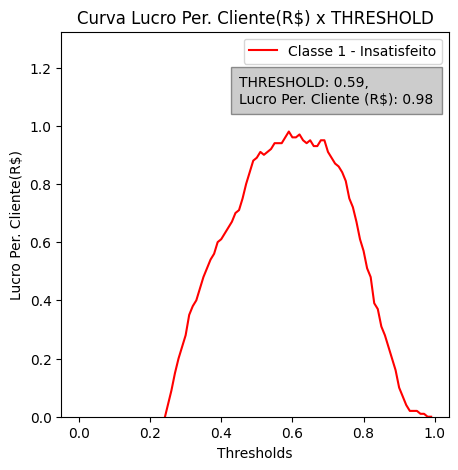

In [256]:
thresholdsCurve(yVal, yPred_prob)

### 1.4.1 - LGBM

In [257]:
bestParamsLGBM['learning_rate'] = np.arange(0.05, 0.35, 0.02)[3]
bestParamsLGBM['n_estimators'] = int(bestParamsLGBM['n_estimators'])
bestParamsLGBM['max_depth'] = int(bestParamsLGBM['max_depth'])

In [258]:
classifierLGBM = lgb.LGBMClassifier(verbose = -1, 
                                    n_jobs = -1, 
                                    objective='binary', 
                                    random_state=424, 
                                    **bestParamsLGBM)

In [259]:
classifierLGBM.fit(dfTrainCLF, yTrain)

LGBMClassifier(colsample_bytree=0.2903871114466451,
               learning_rate=0.11000000000000001, max_depth=16,
               min_child_weight=5.0, n_estimators=2313, n_jobs=-1,
               objective='binary', random_state=424,
               reg_alpha=5.050663267632806, reg_lambda=10.882386452313039,
               subsample=0.011191504578942149, verbose=-1)

In [260]:
yPred_prob_train = classifierLGBM.predict_proba(dfTrainCLF)
yPred_prob = classifierLGBM.predict_proba(dfValCLF)

In [261]:
auc_train = roc_auc_score(yTrain, yPred_prob_train[:,1])
auc_val = roc_auc_score(yVal, yPred_prob[:,1])

print(f"AUC Train: {auc_train:.4f}")
print(f"AUC Val: {auc_val:.4f}")

AUC Train: 0.8882
AUC Val: 0.8463


In [262]:
print("Distribuição no dataset de Treino")
computeDist(yTrain, yPred_prob_train)

Distribuição no dataset de Treino


,Target_AC,Max_proba,Min_proba,Lift
Percentil,,,,
1,13.911386,0.817482,0.279670,13.892904
5,40.495474,0.202315,0.183880,8.097057
10,60.171510,0.122194,0.111061,6.016718
20,79.752263,0.052424,0.049201,3.987326
30,88.708909,0.031409,0.030266,2.956928
40,92.710815,0.020634,0.019784,2.317708
50,95.759886,0.013665,0.013351,1.915198
60,97.951405,0.009263,0.008898,1.632504
70,98.761315,0.006230,0.005991,1.410883


In [263]:
print("Distribuição no dataset de Validação")
computeDist(yVal, yPred_prob)

Distribuição no dataset de Validação


,Target_AC,Max_proba,Min_proba,Lift
Percentil,,,,
1,8.113208,0.675636,0.279745,8.102275
5,33.396226,0.205442,0.184221,6.670245
10,53.584906,0.124556,0.112236,5.355068
20,72.452830,0.053357,0.050112,3.621613
30,80.943396,0.031552,0.030378,2.697666
40,87.735849,0.020701,0.019896,2.193163
50,91.886792,0.013564,0.013213,1.837605
60,95.283019,0.009418,0.008964,1.587975
70,97.169811,0.006230,0.005988,1.388098


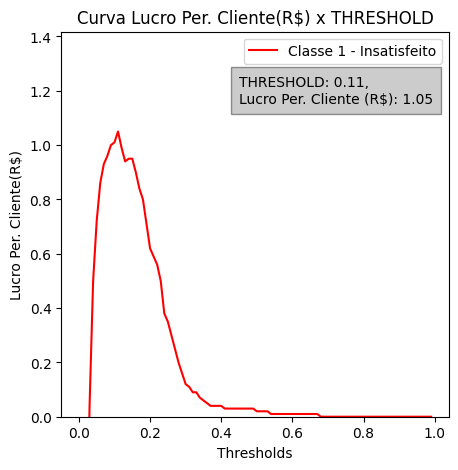

In [32]:
thresholdsCurve(yVal, yPred_prob)

In [264]:
yPred = yPred_prob[:,1] >= 0.11
profitClient, profit = scoringProfit(yVal, yPred, True)
profitClientMax, profitMax = scoringProfit(yVal, yVal, True)

print(f'Lucro máximo por cliente {profitClient:,.2f}')
print(f'Lucro máximo da campanha: R$ {profit:,.2f}')
print(f'Lucro máximo que poderia ser atingindo na campanha: R$ {profitMax:,.2f}')
print(f'Lucro máximo em %: {profit/profitMax:.2%}')

Lucro máximo por cliente 1.05
Lucro máximo da campanha: R$ 14,720.00
Lucro máximo que poderia ser atingindo na campanha: R$ 47,700.00
Lucro máximo em %: 30.86%


## 1.5 - Explicabilidade do Melhor Modelo (SHAP Values)

In [265]:
shap.initjs()
explainer = shap.TreeExplainer(classifierLGBM)
shap_values = explainer.shap_values(dfValCLF)

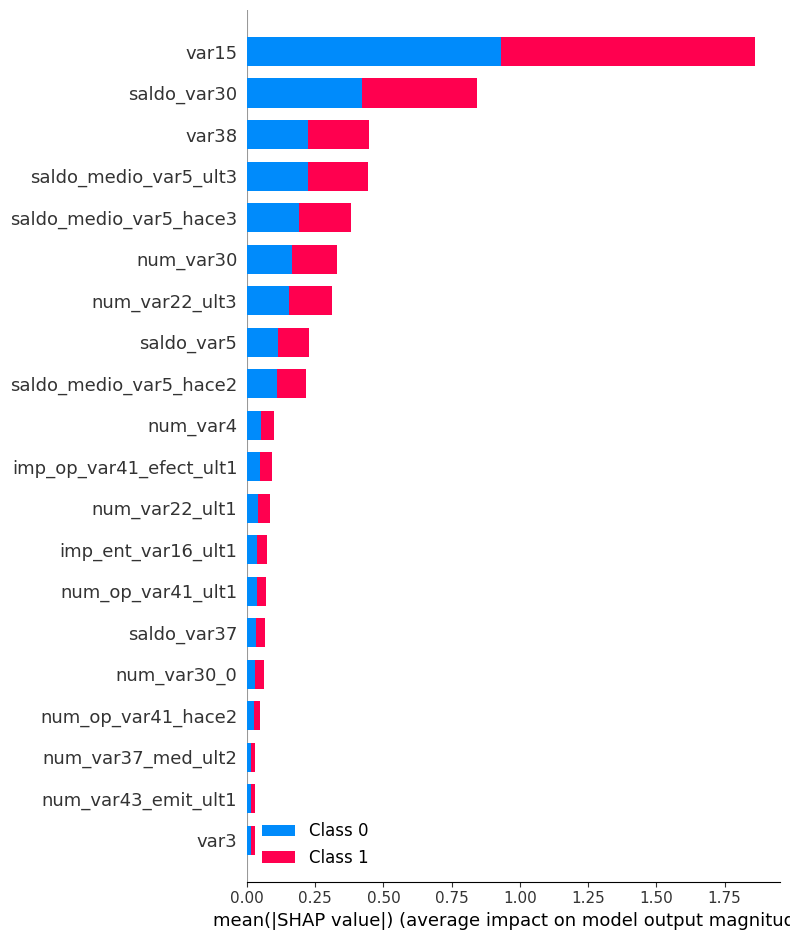

In [266]:
shap.summary_plot(shap_values, dfValCLF, feature_names=modelTransform.get_feature_names_out())

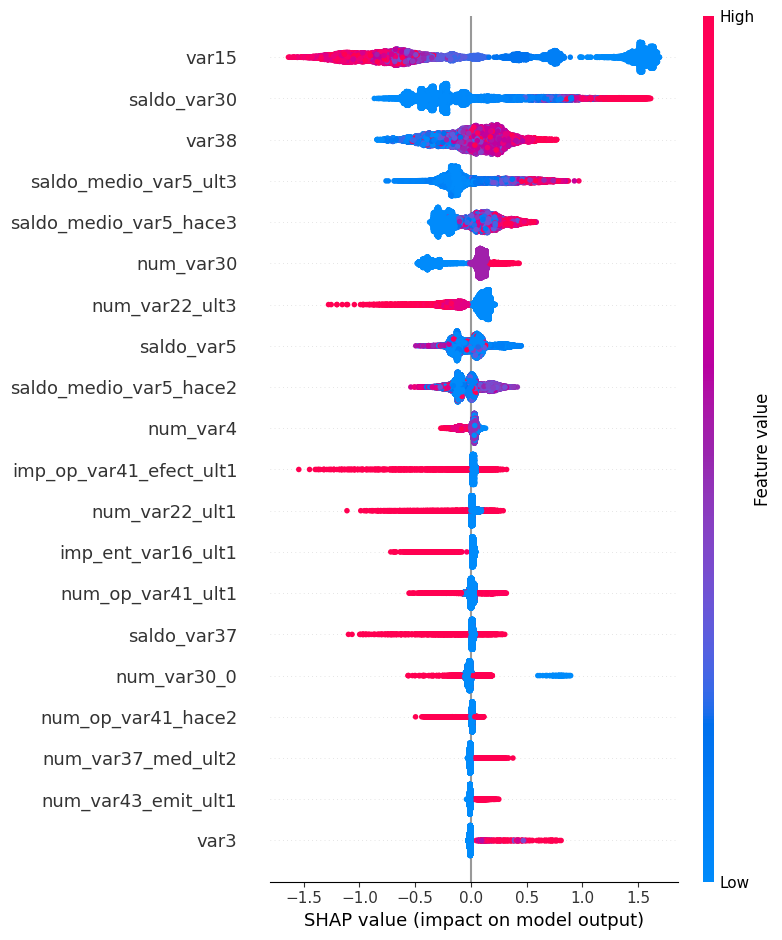

In [267]:
shap.summary_plot(shap_values[0], dfValCLF, feature_names=modelTransform.get_feature_names_out())

# 2.0 - Notas (Case B)

In [268]:
yPred_prob_test = classifierLGBM.predict_proba(dfTestCLF)

A quantidade de publico no segmento 1 é menor pois trata-se do público categorizado como insatisfeito pelo modelo


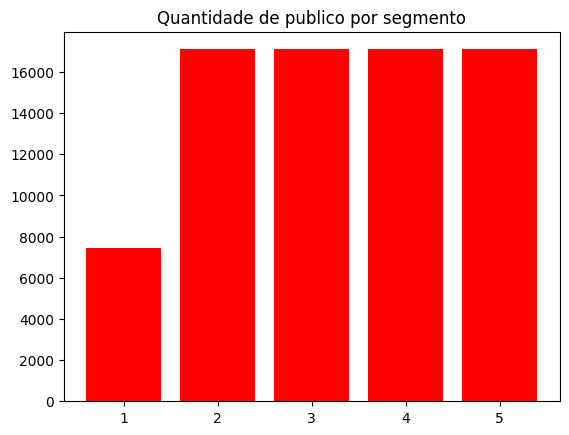

In [269]:
# ### Separar os clientes classificados como insatisfeitos pelo modelo
df_preds_1 =  pd.DataFrame(yPred_prob_test[yPred_prob_test[:,1] >= 0.11][:,1] >= 0.11*1)
df_preds_0 =  pd.DataFrame(yPred_prob_test[yPred_prob_test[:,1] < 0.11][:,1])

# ### Dividir os registros classificados como satisfeitos em quartis baseados na probabilidade de serem insatisfeitos
decil_preds_0 = pd.qcut(df_preds_0[0].rank(method='first'), q = 4, labels = [2, 3, 4, 5])
pub_segmentado = np.concatenate((df_preds_1, decil_preds_0), axis=None)
segmentos, quantidade = np.unique(pub_segmentado, return_counts=True)

# ### Plot
plt.bar(segmentos, quantidade, color='red')
plt.title('Quantidade de publico por segmento');
print('A quantidade de publico no segmento 1 é menor pois trata-se do público categorizado como insatisfeito pelo modelo')


# 3.0 - Clustering (Agrupamento)

In [17]:
def optimalNumberClustersElbow(wcss, min_cluster, max_cluster):
    '''
        Compute the best number of cluster based on Elbow method
    '''
    
    x1, y1 = min_cluster, wcss[0]
    x2, y2 = (max_cluster-1), wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+4
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)

    return distances.index(max(distances)) + min_cluster

In [18]:
def computeBestCluster(data, min_cluster=4, max_cluster=21):
    '''
        Compute the best number of cluster based on Silhueta Score
    '''
    
    wcss = []
    scores_silhueta = []
    scores_calinski = []
    scores_davies = []
    
    for nClusters in range(min_cluster, max_cluster):
        
        # ### Train kmeans model
        kmeans_model = KMeans(n_clusters = nClusters, n_init=50, random_state = 42)
        kmeans_model.fit(data)
        
        # ### Predict
        pred = kmeans_model.predict(data)
    
        # ### Compute WCSS (Elbow)
        wcss.append(kmeans_model.inertia_)
        
        # ### Compute silhouette score
        score_sil = silhouette_score(data, pred)
        score_dav = davies_bouldin_score(data, pred)
        score_cal = calinski_harabasz_score(data, pred)
        
        scores_silhueta.append(score_sil)
        scores_davies.append(score_dav)
        scores_calinski.append(score_cal)
        
        print(f'Silhouette Score para {nClusters} clusters: {score_sil:.5f}')
        print(f'Davies Score para {nClusters} clusters: {score_dav:.5f}')
        print(f'Calinski Score para {nClusters} clusters: {score_cal:.5f}\n')

    print(f"\n Melhor número de clusters de acordo com o Silhueta Score {max(scores_silhueta)}: {scores_silhueta.index(max(scores_silhueta)) + min_cluster}")
    print(f"\n Melhor número de clusters de acordo com o Davies-Bouldin Score {min(scores_davies)}: {scores_davies.index(min(scores_davies)) + min_cluster}")
    print(f"\n Melhor número de clusters de acordo com o Calinski-Harabasz Score {max(scores_calinski)}: {scores_calinski.index(max(scores_calinski)) + min_cluster}")
    print(f"\n Melhor número de clusters de acordo com o Método Elow: {optimalNumberClustersElbow(wcss, min_cluster, max_cluster)}")

    return wcss

In [19]:
def benchKmeas(best_k, x_train_scaled, x_val_scaled, yTrain, yVal):

    model = KMeans(n_clusters = best_k, n_init=50, random_state = 42)
    model.fit(x_train_scaled)

    cluster_train = model.predict(x_train_scaled)
    cluster_val = model.predict(x_val_scaled)

    df_cluster_train = pd.DataFrame({'cluster': cluster_train}).join(yTrain)
    df_cluster_train.columns = ['label','target']

    data_train = pd.crosstab(df_cluster_train['label'],df_cluster_train['target'])
    data_train['Ganho'] = data_train [1]*90 
    data_train['Perda'] = data_train[0]*10
    data_train['Lucro'] = data_train['Ganho'] - data_train['Perda']

    
    df_cluster_val = pd.DataFrame({'cluster': cluster_val}).join(yVal)
    df_cluster_val.columns = ['label','target']

    data_val = pd.crosstab(df_cluster_val['label'],df_cluster_val['target'])
    data_val['Ganho'] = data_val [1]*90 
    data_val['Perda'] = data_val[0]*10
    data_val['Lucro'] = data_val['Ganho'] - data_val['Perda']

    print(f'Top 3 clusters para o kmeans - Usando {best_k} clusters')
    print('\nTreino:')
    print(data_train.sort_values(by='Lucro', ascending=False).head(3))
    
    print('\nValidação:')
    print(data_val.sort_values(by='Lucro', ascending=False).head(3))

In [20]:
min_cluster=4
max_cluster=21

## 3.1 - Removendo Todos os Dados Duplicadas no Treino e Validação 

### 3.1.1 - Testar usando a normalização MinMaxScaler

In [30]:
# ### Scaler feature for clustering
scaler = MinMaxScaler()
scaler.fit(dfTrain)

# ### Apply in train and val
x_train_scaled = scaler.transform(dfTrain)
x_val_scaled = scaler.transform(dfVal)

In [31]:
# ### Calcular o melhor Cluster
wcss = computeBestCluster(x_train_scaled, min_cluster, max_cluster)

Silhouette Score para 4 clusters: 0.41210
Davies Score para 4 clusters: 1.05426
Calinski Score para 4 clusters: 16183.17189

Silhouette Score para 5 clusters: 0.45110
Davies Score para 5 clusters: 1.24336
Calinski Score para 5 clusters: 16331.17271

Silhouette Score para 6 clusters: 0.46071
Davies Score para 6 clusters: 1.16205
Calinski Score para 6 clusters: 15437.31731

Silhouette Score para 7 clusters: 0.46533
Davies Score para 7 clusters: 1.17739
Calinski Score para 7 clusters: 14658.42805

Silhouette Score para 8 clusters: 0.46713
Davies Score para 8 clusters: 1.26540
Calinski Score para 8 clusters: 14088.35312

Silhouette Score para 9 clusters: 0.47717
Davies Score para 9 clusters: 1.22075
Calinski Score para 9 clusters: 13791.34272

Silhouette Score para 10 clusters: 0.48236
Davies Score para 10 clusters: 1.18005
Calinski Score para 10 clusters: 13212.18715

Silhouette Score para 11 clusters: 0.47345
Davies Score para 11 clusters: 1.15769
Calinski Score para 11 clusters: 12756.6

### 3.1.1.1 - Com base na Silhueta Score

In [32]:
benchKmeas(16, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 16 clusters

Treino:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
12      157    5    450   1570  -1120
11      204    8    720   2040  -1320
10      278   14   1260   2780  -1520

Validação:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
11       42    2    180    420   -240
12       37    1     90    370   -280
3       109    6    540   1090   -550


### 3.1.1.2 - Com base no Davies-Bouldin Score

In [37]:
benchKmeas(4, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 4 clusters

Treino:
target    0.0  1.0  Ganho   Perda  Lucro
label                                   
1        1541   59   5310   15410 -10100
3        1828   71   6390   18280 -11890
2       12720  522  46980  127200 -80220

Validação:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
1        377   18   1620   3770  -2150
3        473   20   1800   4730  -2930
2       3330  129  11610  33300 -21690


### 3.1.1.3 - Com base no Calinski-Harabasz Score

In [38]:
benchKmeas(5, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 5 clusters

Treino:
target    0.0  1.0  Ganho   Perda  Lucro
label                                   
1        1524   59   5310   15240  -9930
4        1483   54   4860   14830  -9970
2       10477  428  38520  104770 -66250

Validação:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
1        371   18   1620   3710  -2090
4        379   13   1170   3790  -2620
2       2755  110   9900  27550 -17650


### 3.1.1.4 - Com base no Elbow

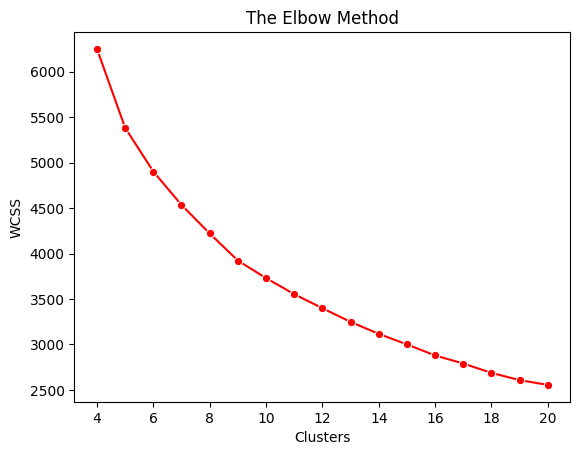

In [39]:
mycenters = pd.DataFrame({'Clusters' : range(min_cluster, max_cluster), 'WCSS' : wcss})
sns.lineplot(x = 'Clusters', y = 'WCSS', data = mycenters, marker="o", color='red')
plt.title('The Elbow Method')
plt.show()

In [40]:
benchKmeas(9, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 9 clusters

Treino:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
7       510    9    810   5100  -4290
4       711   30   2700   7110  -4410
5       795   26   2340   7950  -5610

Validação:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
7       129    5    450   1290   -840
4       180    6    540   1800  -1260
5       212    9    810   2120  -1310


### 3.1.2 - Testar usando a normalização StandardScaler

In [41]:
# ### Scaler feature for clustering
scaler = StandardScaler()
scaler.fit(dfTrain)

# ### Apply in train and val
x_train_scaled = scaler.transform(dfTrain)
x_val_scaled = scaler.transform(dfVal)

In [42]:
# ### Calcular o melhor Cluster
wcss = computeBestCluster(x_train_scaled, min_cluster, max_cluster)

Silhouette Score para 4 clusters: 0.55692
Davies Score para 4 clusters: 1.77022
Calinski Score para 4 clusters: 6274.05775

Silhouette Score para 5 clusters: 0.47944
Davies Score para 5 clusters: 1.86172
Calinski Score para 5 clusters: 5864.06118

Silhouette Score para 6 clusters: 0.29145
Davies Score para 6 clusters: 1.82502
Calinski Score para 6 clusters: 5536.94287

Silhouette Score para 7 clusters: 0.29456
Davies Score para 7 clusters: 1.66846
Calinski Score para 7 clusters: 5366.06843

Silhouette Score para 8 clusters: 0.30375
Davies Score para 8 clusters: 1.52835
Calinski Score para 8 clusters: 5266.89969

Silhouette Score para 9 clusters: 0.30718
Davies Score para 9 clusters: 1.51907
Calinski Score para 9 clusters: 5295.02899

Silhouette Score para 10 clusters: 0.30301
Davies Score para 10 clusters: 1.39587
Calinski Score para 10 clusters: 5246.68851

Silhouette Score para 11 clusters: 0.31250
Davies Score para 11 clusters: 1.37866
Calinski Score para 11 clusters: 5244.38041

Si

### 3.1.2.1 - Com base na Silhueta Score

In [43]:
benchKmeas(4, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 4 clusters

Treino:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
3        379   12   1080   3790  -2710
2       2948  118  10620  29480 -18860
1       4003  164  14760  40030 -25270

Validação:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
3         83    2    180    830   -650
2        744   32   2880   7440  -4560
1       1056   48   4320  10560  -6240


### 3.1.2.2 - Com base no Davies-Bouldin Score

In [44]:
benchKmeas(17, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 17 clusters

Treino:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
16       10    3    270    100    170
8        35    2    180    350   -170
3        33    1     90    330   -240

Validação:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
3         9    2    180     90     90
16        3    0      0     30    -30
14       27    2    180    270    -90


### 3.1.2.3 - Com base no Calinski-Harabasz Score

In [45]:
benchKmeas(4, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 4 clusters

Treino:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
3        379   12   1080   3790  -2710
2       2948  118  10620  29480 -18860
1       4003  164  14760  40030 -25270

Validação:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
3         83    2    180    830   -650
2        744   32   2880   7440  -4560
1       1056   48   4320  10560  -6240


### 3.1.2.4 - Com base no Elbow

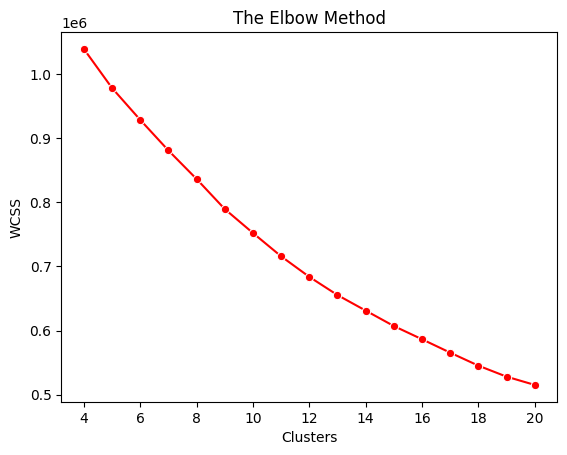

In [46]:
mycenters = pd.DataFrame({'Clusters' : range(min_cluster, max_cluster), 'WCSS' : wcss})
sns.lineplot(x = 'Clusters', y = 'WCSS', data = mycenters, marker="o", color='red')
plt.title('The Elbow Method')
plt.show()

In [48]:
benchKmeas(11, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 11 clusters

Treino:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
7        39    1     90    390   -300
9        85    6    540    850   -310
8       216   10    900   2160  -1260

Validação:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
7        13    2    180    130     50
9        27    2    180    270    -90
8        40    0      0    400   -400


### 3.1.3 - Testar usando a normalização yeo-johnson

In [49]:
# ### Scaler feature for clustering
scaler = PowerTransformer(method='yeo-johnson')
scaler.fit(dfTrain)

# ### Apply in train and val
x_train_scaled = scaler.transform(dfTrain)
x_val_scaled = scaler.transform(dfVal)

In [50]:
# ### Calcular o melhor Cluster
wcss = computeBestCluster(x_train_scaled, min_cluster, max_cluster)

Silhouette Score para 4 clusters: 0.38463
Davies Score para 4 clusters: 1.87851
Calinski Score para 4 clusters: 7686.83997

Silhouette Score para 5 clusters: 0.20777
Davies Score para 5 clusters: 1.77392
Calinski Score para 5 clusters: 7146.13818

Silhouette Score para 6 clusters: 0.22245
Davies Score para 6 clusters: 1.68792
Calinski Score para 6 clusters: 6852.46076

Silhouette Score para 7 clusters: 0.23671
Davies Score para 7 clusters: 1.62807
Calinski Score para 7 clusters: 6587.52025

Silhouette Score para 8 clusters: 0.24231
Davies Score para 8 clusters: 1.53004
Calinski Score para 8 clusters: 6445.36795

Silhouette Score para 9 clusters: 0.24690
Davies Score para 9 clusters: 1.45790
Calinski Score para 9 clusters: 6274.85117

Silhouette Score para 10 clusters: 0.26474
Davies Score para 10 clusters: 1.41362
Calinski Score para 10 clusters: 6161.07286

Silhouette Score para 11 clusters: 0.26455
Davies Score para 11 clusters: 1.33291
Calinski Score para 11 clusters: 5998.06663

Si

### 3.1.3.1 - Com base na Silhueta Score

In [51]:
benchKmeas(4, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 4 clusters

Treino:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
3       1504   54   4860  15040 -10180
0       5147  211  18990  51470 -32480
2       8768  338  30420  87680 -57260

Validação:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
3        364   20   1800   3640  -1840
0       1371   56   5040  13710  -8670
2       2232   81   7290  22320 -15030


### 3.1.3.2 - Com base no Davies-Bouldin Score

In [52]:
benchKmeas(19, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 19 clusters

Treino:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
16        1    0      0     10    -10
17        4    0      0     40    -40
12        4    0      0     40    -40

Validação:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
17        1    0      0     10    -10
12        2    0      0     20    -20
18       15    1     90    150    -60


### 3.1.3.3 - Com base no Calinski-Harabasz Score

In [53]:
benchKmeas(4, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 4 clusters

Treino:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
3       1504   54   4860  15040 -10180
0       5147  211  18990  51470 -32480
2       8768  338  30420  87680 -57260

Validação:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
3        364   20   1800   3640  -1840
0       1371   56   5040  13710  -8670
2       2232   81   7290  22320 -15030


### 3.1.3.4 - Com base no Elbow

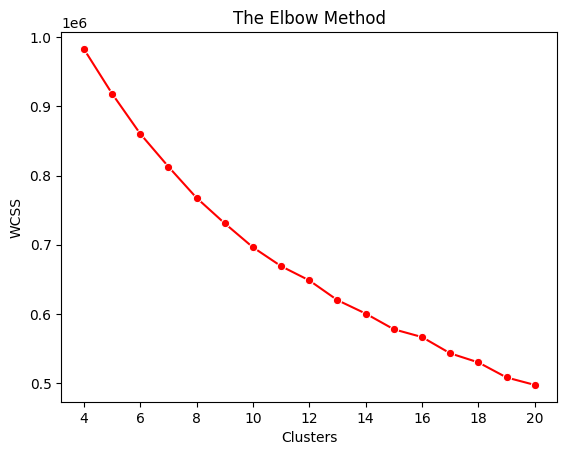

In [54]:
mycenters = pd.DataFrame({'Clusters' : range(min_cluster, max_cluster), 'WCSS' : wcss})
sns.lineplot(x = 'Clusters', y = 'WCSS', data = mycenters, marker="o", color='red')
plt.title('The Elbow Method')
plt.show()

In [56]:
benchKmeas(10, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 10 clusters

Treino:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
3        366   15   1350   3660  -2310
2        601   11    990   6010  -5020
7       1102   39   3510  11020  -7510

Validação:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
3        96    3    270    960   -690
2       151    7    630   1510   -880
7       267   16   1440   2670  -1230


## 3.2 - Removendo Dados com duas Labels no Treino e Validação 

In [7]:
def dropDuplicatedWhithDiferrentTargets(df):
    cols = df.columns.drop('TARGET')
    data = df[df[cols].duplicated()]
    remove = []
    for i in range(len(data)):
        for j in range(i+1, len(data)):
            if (data[cols].iloc[i] == data[cols].iloc[j]).all() and data['TARGET'].iloc[i] != data['TARGET'].iloc[j]:
                remove.append(data.index[j])
                remove .append(data.index[i])

    return df.drop(set(remove))
            

In [8]:
dfTrain.shape

(56757, 26)

In [9]:
dfTrain = dropDuplicatedWhithDiferrentTargets(dfTrain)

In [10]:
dfTrain.shape

(56663, 26)

In [11]:
dfVal.shape

(14190, 26)

In [12]:
dfVal = dropDuplicatedWhithDiferrentTargets(dfVal)

In [13]:
dfVal.shape

(14188, 26)

In [14]:
yTrain = dfTrain.TARGET
dfTrain = dfTrain.drop(labels=['TARGET'], axis=1)

yVal = dfVal.TARGET
dfVal = dfVal.drop(labels=['TARGET'], axis=1)

### 3.2.1 - Testar usando a normalização MinMaxScaler

In [15]:
# ### Scaler feature for clustering
scaler = MinMaxScaler()
scaler.fit(dfTrain)

# ### Apply in train and val
x_train_scaled = scaler.transform(dfTrain)
x_val_scaled = scaler.transform(dfVal)

In [21]:
# ### Calcular o melhor Cluster
wcss = computeBestCluster(x_train_scaled, min_cluster, max_cluster)

Silhouette Score para 4 clusters: 0.41683
Davies Score para 4 clusters: 1.05246
Calinski Score para 4 clusters: 16502.36251

Silhouette Score para 5 clusters: 0.45688
Davies Score para 5 clusters: 1.23863
Calinski Score para 5 clusters: 16701.18863

Silhouette Score para 6 clusters: 0.46633
Davies Score para 6 clusters: 1.15864
Calinski Score para 6 clusters: 15776.93463

Silhouette Score para 7 clusters: 0.47072
Davies Score para 7 clusters: 1.17414
Calinski Score para 7 clusters: 14973.88538

Silhouette Score para 8 clusters: 0.47279
Davies Score para 8 clusters: 1.26353
Calinski Score para 8 clusters: 14387.97714

Silhouette Score para 9 clusters: 0.48251
Davies Score para 9 clusters: 1.21804
Calinski Score para 9 clusters: 14092.33707

Silhouette Score para 10 clusters: 0.48724
Davies Score para 10 clusters: 1.17717
Calinski Score para 10 clusters: 13497.54780

Silhouette Score para 11 clusters: 0.48747
Davies Score para 11 clusters: 1.17454
Calinski Score para 11 clusters: 13056.0

### 3.2.1.1 - Com base na Silhueta Score

In [23]:
benchKmeas(16, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 16 clusters

Treino:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
12      162    3    270   1620  -1350
9       282   13   1170   2820  -1650
15      221    3    270   2210  -1940

Validação:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
8       797   95   8550   7970    580
12       35    3    270    350    -80
9        75    4    360    750   -390


### 3.2.1.2 - Com base no Davies-Bouldin Score

In [24]:
benchKmeas(4, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 4 clusters

Treino:
target    0.0  1.0  Ganho   Perda  Lucro
label                                   
2        1582   53   4770   15820 -11050
0        1867   67   6030   18670 -12640
3       13108  612  55080  131080 -76000

Validação:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
2        369   28   2520   3690  -1170
0        490    9    810   4900  -4090
3       3308  221  19890  33080 -13190


### 3.2.1.3 - Com base no Calinski-Harabasz Score

In [25]:
benchKmeas(5, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 5 clusters

Treino:
target    0.0  1.0  Ganho   Perda  Lucro
label                                   
4        1518   49   4410   15180 -10770
3        1564   53   4770   15640 -10870
0       10734  421  37890  107340 -69450

Validação:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
3        363   27   2430   3630  -1200
4        391    6    540   3910  -3370
1       3299  220  19800  32990 -13190


### 3.2.1.4 - Com base no Elbow

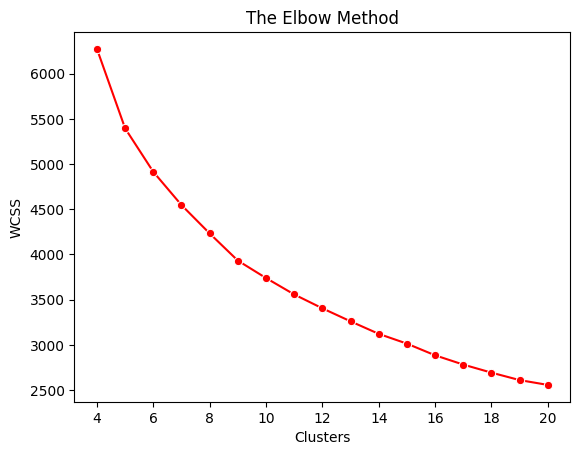

In [26]:
mycenters = pd.DataFrame({'Clusters' : range(min_cluster, max_cluster), 'WCSS' : wcss})
sns.lineplot(x = 'Clusters', y = 'WCSS', data = mycenters, marker="o", color='red')
plt.title('The Elbow Method')
plt.show()

In [27]:
benchKmeas(9, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 9 clusters

Treino:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
8       511   19   1710   5110  -3400
4       730   24   2160   7300  -5140
7       811   24   2160   8110  -5950

Validação:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
8       129    4    360   1290   -930
2       360   27   2430   3600  -1170
4       188    2    180   1880  -1700


### 3.2.2 - Testar usando a normalização StandardScaler

In [28]:
# ### Scaler feature for clustering
scaler = StandardScaler()
scaler.fit(dfTrain)

# ### Apply in train and val
x_train_scaled = scaler.transform(dfTrain)
x_val_scaled = scaler.transform(dfVal)

In [29]:
# ### Calcular o melhor Cluster
wcss = computeBestCluster(x_train_scaled, min_cluster, max_cluster)

Silhouette Score para 4 clusters: 0.56233
Davies Score para 4 clusters: 1.77300
Calinski Score para 4 clusters: 6397.54738

Silhouette Score para 5 clusters: 0.48573
Davies Score para 5 clusters: 1.85991
Calinski Score para 5 clusters: 5980.13754

Silhouette Score para 6 clusters: 0.29736
Davies Score para 6 clusters: 1.82132
Calinski Score para 6 clusters: 5651.96112

Silhouette Score para 7 clusters: 0.30042
Davies Score para 7 clusters: 1.66638
Calinski Score para 7 clusters: 5476.93551

Silhouette Score para 8 clusters: 0.30996
Davies Score para 8 clusters: 1.52413
Calinski Score para 8 clusters: 5377.39906

Silhouette Score para 9 clusters: 0.31349
Davies Score para 9 clusters: 1.52308
Calinski Score para 9 clusters: 5404.29979

Silhouette Score para 10 clusters: 0.31966
Davies Score para 10 clusters: 1.47296
Calinski Score para 10 clusters: 5341.07707

Silhouette Score para 11 clusters: 0.32111
Davies Score para 11 clusters: 1.38564
Calinski Score para 11 clusters: 5354.31869

Si

### 3.2.2.1 - Com base na Silhueta Score

In [30]:
benchKmeas(4, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 4 clusters

Treino:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
0        390    6    540   3900  -3360
2       3068  118  10620  30680 -20060
3       4098  138  12420  40980 -28560

Validação:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
0         86    0      0    860   -860
2        751   47   4230   7510  -3280
3       1097   16   1440  10970  -9530


### 3.2.2.2 - Com base no Davies-Bouldin Score

In [31]:
benchKmeas(20, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 20 clusters

Treino:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
11       35    4    360    350     10
10       12    1     90    120    -30
9        37    0      0    370   -370

Validação:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
3        23    7    630    230    400
9         9    2    180     90     90
10        3    0      0     30    -30


### 3.2.2.3 - Com base no Calinski-Harabasz Score

In [32]:
benchKmeas(4, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 4 clusters

Treino:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
0        390    6    540   3900  -3360
2       3068  118  10620  30680 -20060
3       4098  138  12420  40980 -28560

Validação:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
0         86    0      0    860   -860
2        751   47   4230   7510  -3280
3       1097   16   1440  10970  -9530


### 3.2.2.4 - Com base no Elbow

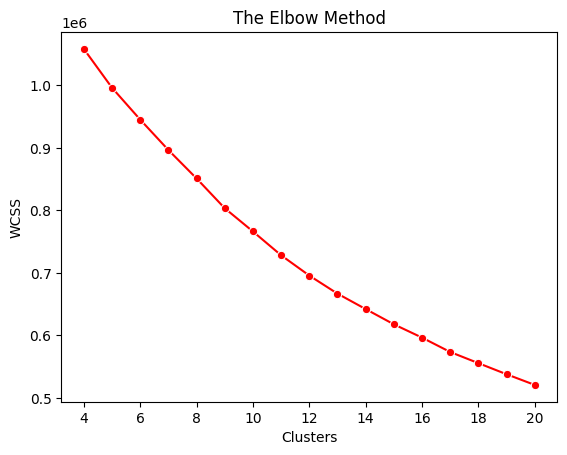

In [33]:
mycenters = pd.DataFrame({'Clusters' : range(min_cluster, max_cluster), 'WCSS' : wcss})
sns.lineplot(x = 'Clusters', y = 'WCSS', data = mycenters, marker="o", color='red')
plt.title('The Elbow Method')
plt.show()

In [34]:
benchKmeas(11, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 11 clusters

Treino:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
8        36    4    360    360      0
4        88    4    360    880   -520
6       222   10    900   2220  -1320

Validação:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
8        15    0      0    150   -150
4        29    0      0    290   -290
6        39    1     90    390   -300


### 3.2.3 - Testar usando a normalização yeo-johnson

In [35]:
# ### Scaler feature for clustering
scaler = PowerTransformer(method='yeo-johnson')
scaler.fit(dfTrain)

# ### Apply in train and val
x_train_scaled = scaler.transform(dfTrain)
x_val_scaled = scaler.transform(dfVal)

In [36]:
# ### Calcular o melhor Cluster
wcss = computeBestCluster(x_train_scaled, min_cluster, max_cluster)

Silhouette Score para 4 clusters: 0.39034
Davies Score para 4 clusters: 1.87686
Calinski Score para 4 clusters: 7832.41411

Silhouette Score para 5 clusters: 0.21136
Davies Score para 5 clusters: 1.77101
Calinski Score para 5 clusters: 7294.07985

Silhouette Score para 6 clusters: 0.22597
Davies Score para 6 clusters: 1.68565
Calinski Score para 6 clusters: 6992.50592

Silhouette Score para 7 clusters: 0.24010
Davies Score para 7 clusters: 1.62511
Calinski Score para 7 clusters: 6721.20090

Silhouette Score para 8 clusters: 0.24562
Davies Score para 8 clusters: 1.52769
Calinski Score para 8 clusters: 6575.74466

Silhouette Score para 9 clusters: 0.25019
Davies Score para 9 clusters: 1.45636
Calinski Score para 9 clusters: 6402.12922

Silhouette Score para 10 clusters: 0.26811
Davies Score para 10 clusters: 1.41182
Calinski Score para 10 clusters: 6286.96729

Silhouette Score para 11 clusters: 0.27940
Davies Score para 11 clusters: 1.39864
Calinski Score para 11 clusters: 6125.69985

Si

### 3.2.3.1 - Com base na Silhueta Score

In [37]:
benchKmeas(4, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 4 clusters

Treino:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
2       1532   54   4860  15320 -10460
3       5259  185  16650  52590 -35940
1       8951  343  30870  89510 -58640

Validação:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
2        356   30   2700   3560   -860
3       1422   18   1620  14220 -12600
1       2244   84   7560  22440 -14880


### 3.2.3.2 - Com base no Davies-Bouldin Score

In [38]:
benchKmeas(17, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 17 clusters

Treino:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
11        1    0      0     10    -10
16       56    1     90    560   -470
0       261   12   1080   2610  -1530

Validação:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
16       14    2    180    140     40
15       94    6    540    940   -400
0        70    2    180    700   -520


### 3.2.3.3 - Com base no Calinski-Harabasz Score

In [39]:
benchKmeas(4, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 4 clusters

Treino:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
2       1532   54   4860  15320 -10460
3       5259  185  16650  52590 -35940
1       8951  343  30870  89510 -58640

Validação:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
2        356   30   2700   3560   -860
3       1422   18   1620  14220 -12600
1       2244   84   7560  22440 -14880


### 3.2.3.4 - Com base no Elbow

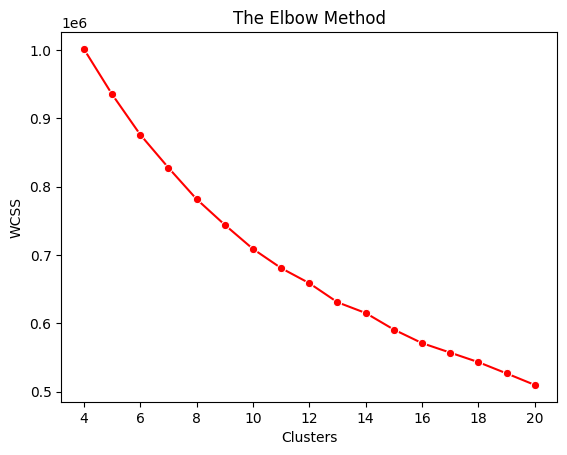

In [40]:
mycenters = pd.DataFrame({'Clusters' : range(min_cluster, max_cluster), 'WCSS' : wcss})
sns.lineplot(x = 'Clusters', y = 'WCSS', data = mycenters, marker="o", color='red')
plt.title('The Elbow Method')
plt.show()

In [41]:
benchKmeas(10, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 10 clusters

Treino:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
9        371   13   1170   3710  -2540
0        613   22   1980   6130  -4150
4       1128   41   3690  11280  -7590

Validação:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
9        94    6    540    940   -400
4       263   21   1890   2630   -740
0       152    6    540   1520   -980


In [7]:
dropDuplicatedRows(dfTest, dfTest.columns, 'last')

Dataset antes do processamento: (75818, 25)
Dataset após o processamento: (69246, 25)
